In [1]:
from asap.data.dataloader import DataSet
from asap.util import topics
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc

sample_in = '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/simdata/simdata_a_1000_r_0.75_d_10000_s_10000_sd_1'
sample_out = '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/simdata/a_1000_r_0.75_d_10000_s_10000_sd_1/'

dl = DataSet(sample_in,sample_out,data_mode='sparse',data_ondisk=False)
dl.initialize_data()
print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/simdata/simdata_a_1000_r_0.75_d_10000_s_10000_sd_1
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/simdata/a_1000_r_0.75_d_10000_s_10000_sd_1/


In [2]:
model = np.load(sample_out+'_dcnmf.npz')

In [31]:
beta = model['beta']
theta = model['theta']
uu = beta.sum(0)
beta = beta/uu
prop = theta * uu
zz = prop.T.sum(0).reshape(theta.shape[0],1)
prop = prop/zz

df_beta = pd.DataFrame(beta.T)
df_beta.columns = dl.cols
df_theta = pd.DataFrame(prop)
df_theta.index = dl.rows
df_corr = pd.DataFrame(model['corr'])
df_corr.index = dl.rows

In [6]:
df_beta = pd.DataFrame(model['beta'].T)
df_beta.columns = dl.cols
df_theta = pd.DataFrame(model['corr'])
df_theta.index = dl.rows

In [22]:
df_theta.shape

(15000, 25)

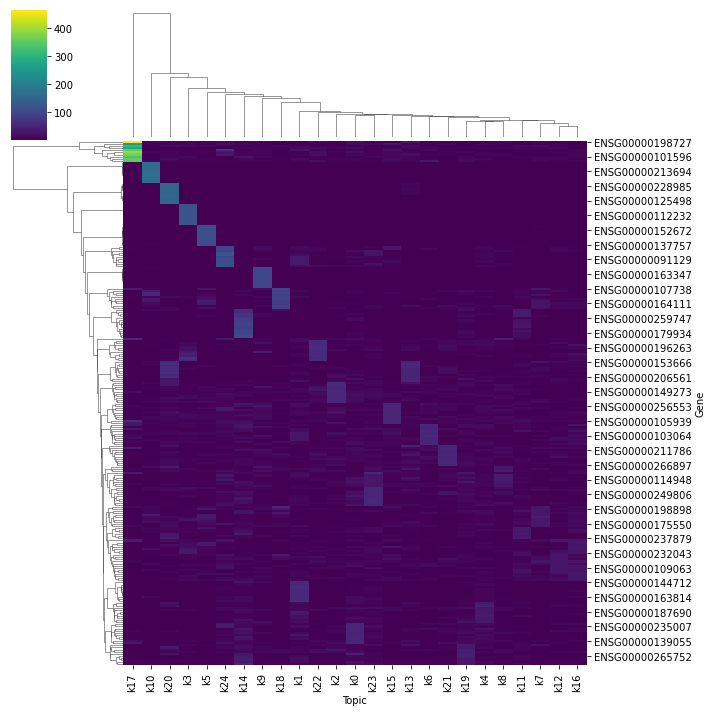

In [4]:
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
# df_top[df_top>20] = 20
sns.clustermap(df_top.T,cmap='viridis')

In [8]:
import umap

df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows
df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.9,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

# df_umap = pd.read_csv(sample_out+'_theta_umap.csv')
# df_umap.columns = ['cell','umap1','umap2']


,cell,topic_bulk,umap1,umap2
0,"0_Tcell,CD4,naive[activated]",9,6.242082,8.193131
1,"1_Tcell,CD4,naive[activated]",9,7.560696,8.295576
2,"2_Tcell,CD4,naive[activated]",9,7.622966,9.650443
3,"3_Tcell,CD4,naive[activated]",9,5.144183,9.253588
4,"4_Tcell,CD4,naive[activated]",9,7.507226,11.245342
...,...,...,...,...
104995,"6995_Tcell,CD8,naive[activated]",9,17.782799,6.712131
104996,"6996_Tcell,CD8,naive[activated]",17,17.111107,3.765560
104997,"6997_Tcell,CD8,naive[activated]",17,18.103889,2.574938
104998,"6998_Tcell,CD8,naive[activated]",17,20.080462,4.585541


Text(0, 0.5, 'UMAP2')

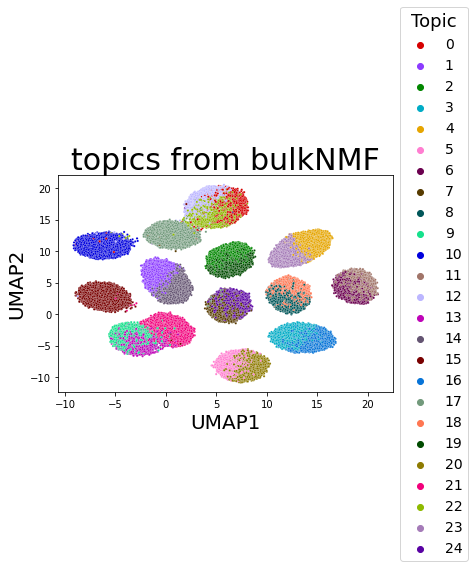

In [19]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

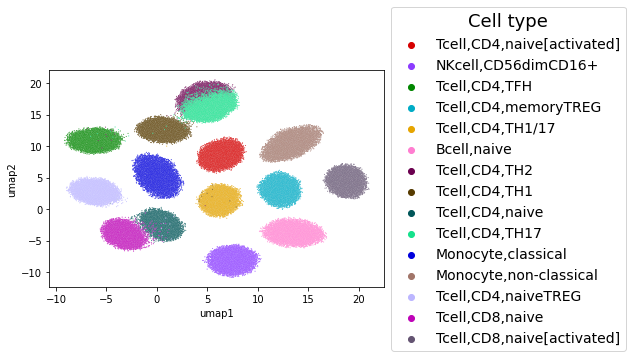

In [11]:
df_umap['cell_type'] = [x.split('_')[1] for x in df_umap['cell']]
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=1,palette=cp,legend=True)
plt.legend(title='Cell type',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
# p.axes.set_title("topics from bulkNMF",fontsize=30)
# p.set_xlabel("UMAP1",fontsize=20)
# p.set_ylabel("UMAP2",fontsize=20)

In [17]:
bulk_data = '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/resources/dice/mean_tpm_merged.csv.gz'
df_dice = pd.read_csv(bulk_data,compression='zip')

df_dice = df_dice.set_index('gene').T

In [18]:
df_beta.index

RangeIndex(start=0, stop=25, step=1)

Text(218.45454545454544, 0.5, 'bulk')

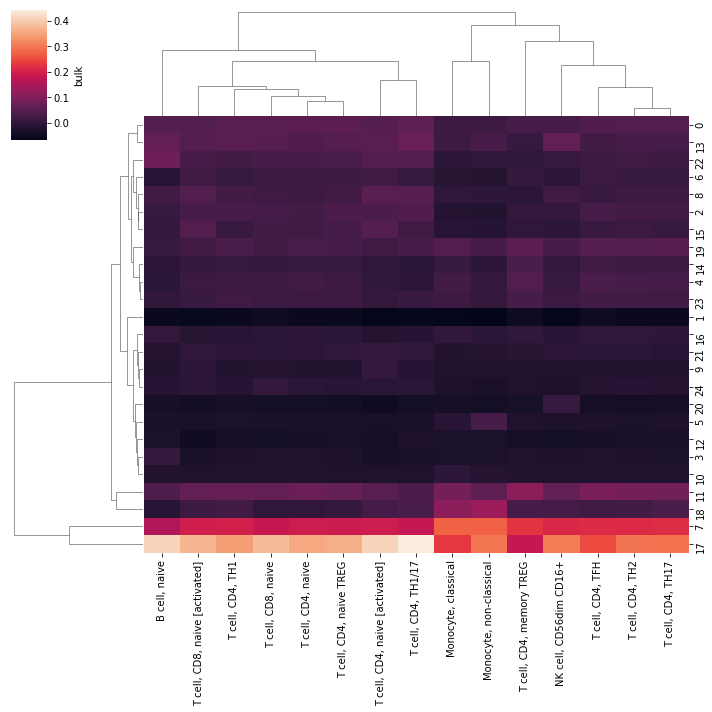

In [18]:
sel_top_genes = list(np.unique(topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)['Gene'].values))
K=10
corr=[]
for i in df_beta.index:
    cr = []
    for j in df_dice.index:
        cr.append(np.corrcoef(df_beta.loc[i,sel_top_genes],df_dice.loc[j,sel_top_genes])[0,1])
    corr.append(cr)

df_corr = pd.DataFrame(corr)
df_corr.index = df_beta.index
df_corr.columns = df_dice.index
sns.clustermap(df_corr)
plt.xlabel('sc')
plt.ylabel('bulk')

In [37]:
df_match = df_umap[['cell','cell_type','topic_bulk']]
df_match = df_match.groupby(['cell_type','topic_bulk']).count().reset_index()
df_match = df_match.pivot('cell_type','topic_bulk')
df_match = df_match.fillna(0)
df_match

cell                                       \
topic_bulk                      4       5      6      7      10      13   
cell_type                                                                 
Bcell,naive                    0.0     0.0    0.0    0.0    0.0     0.0   
Monocyte,classical             0.0     0.0    0.0    0.0    0.0     0.0   
Monocyte,non-classical         0.0     0.0    0.0    0.0    0.0     0.0   
NKcell,CD56dimCD16+            0.0  1000.0    0.0    0.0    0.0     0.0   
Tcell,CD4,TFH                  0.0     0.0    0.0  978.0    0.0     0.0   
Tcell,CD4,TH1                  0.0   194.0    0.0   24.0    0.0   782.0   
Tcell,CD4,TH1/17               0.0     0.0    0.0    0.0    0.0  1000.0   
Tcell,CD4,TH17                 0.0     0.0    0.0  612.0    0.0   377.0   
Tcell,CD4,TH2                  0.0     0.0    0.0  939.0    0.0    60.0   
Tcell,CD4,memoryTREG           0.0     0.0    0.0    0.0    0.0     0.0   
Tcell,CD4,naive                0.0     0.0  210.0  454.0  221.0     2.0   
Tcell,CD4,naiveTREG            0.0     0.0    0.0  999.0    1.0     0.0   
Tcell,CD4,naive[activated]  1000.0     0.0    0.0    0.0    0.0     0.0   
Tcell,CD8,naive                0.0   745.0    0.0  158.0   95.0     0.0   
Tcell,CD8,naive[activated]  1000.0     0.0    0.0    0.0    0.0     0.0   

                                                                
topic_bulk                      17     18      20   21      22  
cell_type                                                       
Bcell,naive                    0.0    0.0  1000.0  0.0     0.0  
Monocyte,classical             0.0    0.0     0.0  0.0  1000.0  
Monocyte,non-classical         0.0    0.0     0.0  3.0   997.0  
NKcell,CD56dimCD16+            0.0    0.0     0.0  0.0     0.0  
Tcell,CD4,TFH                 22.0    0.0     0.0  0.0     0.0  
Tcell,CD4,TH1                  0.0    0.0     0.0  0.0     0.0  
Tcell,CD4,TH1/17               0.0    0.0     0.0  0.0     0.0  
Tcell,CD4,TH17                11.0    0.0     0.0  0.0     0.0  
Tcell,CD4,TH2                  1.0    0.0     0.0  0.0     0.0  
Tcell,CD4,memoryTREG        1000.0    0.0     0.0  0.0     0.0  
Tcell,CD4,naive                0.0  113.0     0.0  0.0     0.0  
Tcell,CD4,naiveTREG            0.0    0.0     0.0  0.0     0.0  
Tcell,CD4,naive[activated]     0.0    0.0     0.0  0.0     0.0  
Tcell,CD8,naive                0.0    2.0     0.0  0.0     0.0  
Tcell,CD8,naive[activated]     0.0    0.0     0.0  0.0     0.0

In [ ]:
sns.clustermap(df_match)

In [12]:
df_match.values

NameError: name 'df_match' is not defined

In [15]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(df_umap['cell_type'].values,df_umap['topic_bulk'].values)

0.8881611754060522

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(df_theta.to_numpy())
kmeans = KMeans(n_clusters=25, init='k-means++',random_state=0).fit(scaled)
df_umap['topic_bulk'] = kmeans.labels_
df_umap['cell_type'] = [x.split('_')[1] for x in df_umap['cell']]